In [1]:
!bash download_data.sh

--2018-11-11 20:55:19--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  4.92MB/s    in 70s     

2018-11-11 20:56:30 (6.25 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2018-11-11 20:56:31--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

In [3]:
import sys
sys.path.append('.local/lib/python3.5/site-packages')

In [1]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effictively.

In [4]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


In [5]:
learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

In [6]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the dector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [7]:
file_root_train = 'VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [8]:
file_root_test = 'VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


## Train detector

In [9]:
best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')
    




Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
24
24
24
24
24
Epoch [1/50], Iter [5/209] Loss: 65.6879, average_loss: 69.4378
24
24
24
24
24
Epoch [1/50], Iter [10/209] Loss: 42.2458, average_loss: 60.6060
24
24
24
24
24
Epoch [1/50], Iter [15/209] Loss: 24.0236, average_loss: 51.3178
24
24
24
24
24
Epoch [1/50], Iter [20/209] Loss: 17.3097, average_loss: 43.3452
24
24
24
24
24
Epoch [1/50], Iter [25/209] Loss: 13.3500, average_loss: 37.6687
24
24
24
24
24
Epoch [1/50], Iter [30/209] Loss: 10.7645, average_loss: 33.9599
24
24
24
24
24
Epoch [1/50], Iter [35/209] Loss: 12.0206, average_loss: 30.7107
24
24
24
24
24
Epoch [1/50], Iter [40/209] Loss: 9.7506, average_loss: 28.0264
24
24
24
24
24
Epoch [1/50], Iter [45/209] Loss: 8.0579, average_loss: 25.9670
24
24
24
24
24
Epoch [1/50], Iter [50/209] Loss: 7.0559, average_loss: 24.2046
24
24
24
24
24
Epoch [1/50], Iter [55/209] Loss: 7.2270, average_loss: 22.6728
24
24
24
24
24
Epoch [1/50], Iter [60/209] Loss: 8.7898, average_

24
24
24
24
Epoch [3/50], Iter [20/209] Loss: 4.0483, average_loss: 4.3858
24
24
24
24
24
Epoch [3/50], Iter [25/209] Loss: 3.4506, average_loss: 4.3882
24
24
24
24
24
Epoch [3/50], Iter [30/209] Loss: 3.9365, average_loss: 4.4589
24
24
24
24
24
Epoch [3/50], Iter [35/209] Loss: 6.7469, average_loss: 4.5520
24
24
24
24
24
Epoch [3/50], Iter [40/209] Loss: 2.7027, average_loss: 4.4753
24
24
24
24
24
Epoch [3/50], Iter [45/209] Loss: 5.3099, average_loss: 4.4499
24
24
24
24
24
Epoch [3/50], Iter [50/209] Loss: 4.2617, average_loss: 4.4288
24
24
24
24
24
Epoch [3/50], Iter [55/209] Loss: 5.3999, average_loss: 4.4736
24
24
24
24
24
Epoch [3/50], Iter [60/209] Loss: 5.3047, average_loss: 4.5154
24
24
24
24
24
Epoch [3/50], Iter [65/209] Loss: 3.7512, average_loss: 4.4645
24
24
24
24
24
Epoch [3/50], Iter [70/209] Loss: 3.0732, average_loss: 4.4606
24
24
24
24
24
Epoch [3/50], Iter [75/209] Loss: 3.8658, average_loss: 4.4490
24
24
24
24
24
Epoch [3/50], Iter [80/209] Loss: 4.0771, average_lo

24
24
24
24
Epoch [5/50], Iter [40/209] Loss: 4.9048, average_loss: 3.6856
24
24
24
24
24
Epoch [5/50], Iter [45/209] Loss: 2.9042, average_loss: 3.7100
24
24
24
24
24
Epoch [5/50], Iter [50/209] Loss: 3.2386, average_loss: 3.7165
24
24
24
24
24
Epoch [5/50], Iter [55/209] Loss: 4.0024, average_loss: 3.7324
24
24
24
24
24
Epoch [5/50], Iter [60/209] Loss: 3.5139, average_loss: 3.7355
24
24
24
24
24
Epoch [5/50], Iter [65/209] Loss: 3.4816, average_loss: 3.7322
24
24
24
24
24
Epoch [5/50], Iter [70/209] Loss: 3.4435, average_loss: 3.7661
24
24
24
24
24
Epoch [5/50], Iter [75/209] Loss: 3.6645, average_loss: 3.7317
24
24
24
24
24
Epoch [5/50], Iter [80/209] Loss: 3.1871, average_loss: 3.7103
24
24
24
24
24
Epoch [5/50], Iter [85/209] Loss: 2.8627, average_loss: 3.7456
24
24
24
24
24
Epoch [5/50], Iter [90/209] Loss: 3.9650, average_loss: 3.7315
24
24
24
24
24
Epoch [5/50], Iter [95/209] Loss: 4.7629, average_loss: 3.7509
24
24
24
24
24
Epoch [5/50], Iter [100/209] Loss: 3.6966, average_l

24
24
24
24
Epoch [7/50], Iter [60/209] Loss: 3.0494, average_loss: 3.4581
24
24
24
24
24
Epoch [7/50], Iter [65/209] Loss: 3.3601, average_loss: 3.4697
24
24
24
24
24
Epoch [7/50], Iter [70/209] Loss: 3.0626, average_loss: 3.4520
24
24
24
24
24
Epoch [7/50], Iter [75/209] Loss: 3.3094, average_loss: 3.4721
24
24
24
24
24
Epoch [7/50], Iter [80/209] Loss: 2.9356, average_loss: 3.4669
24
24
24
24
24
Epoch [7/50], Iter [85/209] Loss: 2.4737, average_loss: 3.4307
24
24
24
24
24
Epoch [7/50], Iter [90/209] Loss: 3.2779, average_loss: 3.4213
24
24
24
24
24
Epoch [7/50], Iter [95/209] Loss: 4.8212, average_loss: 3.4448
24
24
24
24
24
Epoch [7/50], Iter [100/209] Loss: 3.4014, average_loss: 3.4331
24
24
24
24
24
Epoch [7/50], Iter [105/209] Loss: 2.9614, average_loss: 3.4355
24
24
24
24
24
Epoch [7/50], Iter [110/209] Loss: 2.6687, average_loss: 3.4104
24
24
24
24
24
Epoch [7/50], Iter [115/209] Loss: 3.9936, average_loss: 3.4139
24
24
24
24
24
Epoch [7/50], Iter [120/209] Loss: 3.5564, avera

24
24
24
24
Epoch [9/50], Iter [80/209] Loss: 2.7819, average_loss: 3.2882
24
24
24
24
24
Epoch [9/50], Iter [85/209] Loss: 2.8595, average_loss: 3.2815
24
24
24
24
24
Epoch [9/50], Iter [90/209] Loss: 2.5790, average_loss: 3.2521
24
24
24
24
24
Epoch [9/50], Iter [95/209] Loss: 2.9190, average_loss: 3.2445
24
24
24
24
24
Epoch [9/50], Iter [100/209] Loss: 4.4403, average_loss: 3.2400
24
24
24
24
24
Epoch [9/50], Iter [105/209] Loss: 2.9356, average_loss: 3.2505
24
24
24
24
24
Epoch [9/50], Iter [110/209] Loss: 2.3555, average_loss: 3.2559
24
24
24
24
24
Epoch [9/50], Iter [115/209] Loss: 3.0824, average_loss: 3.2419
24
24
24
24
24
Epoch [9/50], Iter [120/209] Loss: 3.1236, average_loss: 3.2324
24
24
24
24
24
Epoch [9/50], Iter [125/209] Loss: 3.8954, average_loss: 3.2480
24
24
24
24
24
Epoch [9/50], Iter [130/209] Loss: 3.3017, average_loss: 3.2397
24
24
24
24
24
Epoch [9/50], Iter [135/209] Loss: 3.3366, average_loss: 3.2358
24
24
24
24
24
Epoch [9/50], Iter [140/209] Loss: 3.1656, a

Epoch [11/50], Iter [95/209] Loss: 3.6419, average_loss: 3.1224
24
24
24
24
24
Epoch [11/50], Iter [100/209] Loss: 2.6771, average_loss: 3.1018
24
24
24
24
24
Epoch [11/50], Iter [105/209] Loss: 3.3813, average_loss: 3.1028
24
24
24
24
24
Epoch [11/50], Iter [110/209] Loss: 3.5851, average_loss: 3.0963
24
24
24
24
24
Epoch [11/50], Iter [115/209] Loss: 2.6084, average_loss: 3.0815
24
24
24
24
24
Epoch [11/50], Iter [120/209] Loss: 3.1873, average_loss: 3.0768
24
24
24
24
24
Epoch [11/50], Iter [125/209] Loss: 3.6093, average_loss: 3.0804
24
24
24
24
24
Epoch [11/50], Iter [130/209] Loss: 2.7349, average_loss: 3.0706
24
24
24
24
24
Epoch [11/50], Iter [135/209] Loss: 2.2342, average_loss: 3.0679
24
24
24
24
24
Epoch [11/50], Iter [140/209] Loss: 3.9570, average_loss: 3.0786
24
24
24
24
24
Epoch [11/50], Iter [145/209] Loss: 3.1413, average_loss: 3.0729
24
24
24
24
24
Epoch [11/50], Iter [150/209] Loss: 3.6168, average_loss: 3.0730
24
24
24
24
24
Epoch [11/50], Iter [155/209] Loss: 2.962

24
24
24
24
Epoch [13/50], Iter [110/209] Loss: 2.3458, average_loss: 2.8747
24
24
24
24
24
Epoch [13/50], Iter [115/209] Loss: 2.4211, average_loss: 2.8658
24
24
24
24
24
Epoch [13/50], Iter [120/209] Loss: 3.3650, average_loss: 2.8782
24
24
24
24
24
Epoch [13/50], Iter [125/209] Loss: 3.3487, average_loss: 2.8867
24
24
24
24
24
Epoch [13/50], Iter [130/209] Loss: 2.3967, average_loss: 2.8823
24
24
24
24
24
Epoch [13/50], Iter [135/209] Loss: 3.0153, average_loss: 2.8878
24
24
24
24
24
Epoch [13/50], Iter [140/209] Loss: 2.7578, average_loss: 2.8850
24
24
24
24
24
Epoch [13/50], Iter [145/209] Loss: 4.4813, average_loss: 2.8982
24
24
24
24
24
Epoch [13/50], Iter [150/209] Loss: 2.4786, average_loss: 2.8829
24
24
24
24
24
Epoch [13/50], Iter [155/209] Loss: 3.4943, average_loss: 2.8890
24
24
24
24
24
Epoch [13/50], Iter [160/209] Loss: 2.9268, average_loss: 2.8928
24
24
24
24
24
Epoch [13/50], Iter [165/209] Loss: 3.4803, average_loss: 2.8946
24
24
24
24
24
Epoch [13/50], Iter [170/209

24
24
24
24
Epoch [15/50], Iter [125/209] Loss: 3.3146, average_loss: 2.7900
24
24
24
24
24
Epoch [15/50], Iter [130/209] Loss: 2.2953, average_loss: 2.7798
24
24
24
24
24
Epoch [15/50], Iter [135/209] Loss: 3.0976, average_loss: 2.7788
24
24
24
24
24
Epoch [15/50], Iter [140/209] Loss: 2.7111, average_loss: 2.7958
24
24
24
24
24
Epoch [15/50], Iter [145/209] Loss: 2.3943, average_loss: 2.7845
24
24
24
24
24
Epoch [15/50], Iter [150/209] Loss: 2.6323, average_loss: 2.7865
24
24
24
24
24
Epoch [15/50], Iter [155/209] Loss: 2.2197, average_loss: 2.7768
24
24
24
24
24
Epoch [15/50], Iter [160/209] Loss: 3.4035, average_loss: 2.7763
24
24
24
24
24
Epoch [15/50], Iter [165/209] Loss: 2.5832, average_loss: 2.7683
24
24
24
24
24
Epoch [15/50], Iter [170/209] Loss: 2.3483, average_loss: 2.7646
24
24
24
24
24
Epoch [15/50], Iter [175/209] Loss: 2.3757, average_loss: 2.7596
24
24
24
24
24
Epoch [15/50], Iter [180/209] Loss: 2.8260, average_loss: 2.7648
24
24
24
24
24
Epoch [15/50], Iter [185/209

24
24
24
24
Epoch [17/50], Iter [140/209] Loss: 2.1753, average_loss: 2.6092
24
24
24
24
24
Epoch [17/50], Iter [145/209] Loss: 2.2025, average_loss: 2.6105
24
24
24
24
24
Epoch [17/50], Iter [150/209] Loss: 2.8031, average_loss: 2.6088
24
24
24
24
24
Epoch [17/50], Iter [155/209] Loss: 2.9590, average_loss: 2.6110
24
24
24
24
24
Epoch [17/50], Iter [160/209] Loss: 2.2043, average_loss: 2.5971
24
24
24
24
24
Epoch [17/50], Iter [165/209] Loss: 2.6360, average_loss: 2.6025
24
24
24
24
24
Epoch [17/50], Iter [170/209] Loss: 2.3742, average_loss: 2.6052
24
24
24
24
24
Epoch [17/50], Iter [175/209] Loss: 2.4985, average_loss: 2.6004
24
24
24
24
24
Epoch [17/50], Iter [180/209] Loss: 2.9127, average_loss: 2.6033
24
24
24
24
24
Epoch [17/50], Iter [185/209] Loss: 2.3320, average_loss: 2.5992
24
24
24
24
24
Epoch [17/50], Iter [190/209] Loss: 2.4082, average_loss: 2.6066
24
24
24
24
24
Epoch [17/50], Iter [195/209] Loss: 2.4001, average_loss: 2.6027
24
24
24
24
24
Epoch [17/50], Iter [200/209

24
24
24
24
Epoch [19/50], Iter [160/209] Loss: 2.3105, average_loss: 2.5441
24
24
24
24
24
Epoch [19/50], Iter [165/209] Loss: 3.2367, average_loss: 2.5427
24
24
24
24
24
Epoch [19/50], Iter [170/209] Loss: 3.0473, average_loss: 2.5518
24
24
24
24
24
Epoch [19/50], Iter [175/209] Loss: 3.2283, average_loss: 2.5498
24
24
24
24
24
Epoch [19/50], Iter [180/209] Loss: 2.3032, average_loss: 2.5440
24
24
24
24
24
Epoch [19/50], Iter [185/209] Loss: 2.5562, average_loss: 2.5449
24
24
24
24
24
Epoch [19/50], Iter [190/209] Loss: 2.6324, average_loss: 2.5404
24
24
24
24
24
Epoch [19/50], Iter [195/209] Loss: 3.0833, average_loss: 2.5412
24
24
24
24
24
Epoch [19/50], Iter [200/209] Loss: 2.6208, average_loss: 2.5382
24
24
24
24
24
Epoch [19/50], Iter [205/209] Loss: 2.7984, average_loss: 2.5371
24
24
24
19
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24

24
24
24
24
Epoch [21/50], Iter [180/209] Loss: 2.7214, average_loss: 2.4123
24
24
24
24
24
Epoch [21/50], Iter [185/209] Loss: 2.5867, average_loss: 2.4183
24
24
24
24
24
Epoch [21/50], Iter [190/209] Loss: 2.8460, average_loss: 2.4286
24
24
24
24
24
Epoch [21/50], Iter [195/209] Loss: 1.9574, average_loss: 2.4321
24
24
24
24
24
Epoch [21/50], Iter [200/209] Loss: 2.0446, average_loss: 2.4332
24
24
24
24
24
Epoch [21/50], Iter [205/209] Loss: 2.5157, average_loss: 2.4327
24
24
24
19
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
2

24
24
24
24
Epoch [23/50], Iter [195/209] Loss: 2.5998, average_loss: 2.3526
24
24
24
24
24
Epoch [23/50], Iter [200/209] Loss: 1.9014, average_loss: 2.3588
24
24
24
24
24
Epoch [23/50], Iter [205/209] Loss: 2.3671, average_loss: 2.3596
24
24
24
19
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
6
Updating best test loss: 2.92904


Starting epoch 24 / 50
Learning Rate for this epoch: 0.001
24
24
24
24
24
Epoch [24/50], Iter [5

24
24
19
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
6


Starting epoch 26 / 50
Learning Rate for this epoch: 0.001
24
24
24
24
24
Epoch [26/50], Iter [5/209] Loss: 2.6401, average_loss: 2.3217
24
24
24
24
24
Epoch [26/50], Iter [10/209] Loss: 2.0020, average_loss: 2.3276
24
24
24
24
24
Epoch [26/50], Iter [15/209] Loss: 2.5409, average_loss: 2.3388
24
24
24
24
24
Epoch [26/50], Iter [20/209] Loss: 2.6615, average_loss: 2.

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
6


Starting epoch 28 / 50
Learning Rate for this epoch: 0.001
24
24
24
24
24
Epoch [28/50], Iter [5/209] Loss: 1.8766, average_loss: 2.0698
24
24
24
24
24
Epoch [28/50], Iter [10/209] Loss: 2.1051, average_loss: 2.1812
24
24
24
24
24
Epoch [28/50], Iter [15/209] Loss: 1.6052, average_loss: 2.2119
24
24
24
24
24
Epoch [28/50], Iter [20/209] Loss: 1.7500, average_loss: 2.1855
24
24
24
24
24
Epoch [28/50], Iter [25/209] Loss: 2.1216, average_loss: 2.1790
24
24
24
24
24
Epoch [28/50], Iter [30/209] Loss: 2.0947, average_loss: 2.1855
24
24
24
24
24
Epoch [28/50], Iter [35/209] Loss: 2.3351, average_loss: 2.1787
24
24
24
24
2

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
6


Starting epoch 30 / 50
Learning Rate for this epoch: 0.001
24
24
24
24
24
Epoch [30/50], Iter [5/209] Loss: 1.7312, average_loss: 2.2936
24
24
24
24
24
Epoch [30/50], Iter [10/209] Loss: 1.9268, average_loss: 2.1162
24
24
24
24
24
Epoch [30/50], Iter [15/209] Loss: 1.6597, average_loss: 2.1885
24
24
24
24
24
Epoch [30/50], Iter [20/209] Loss: 1.8606, average_loss: 2.0531
24
24
24
24
24
Epoch [30/50], Iter [25/209] Loss: 1.7300, average_loss: 1.9992
24
24
24
24
24
Epoch [30/50], Iter [30/209] Loss: 1.5104, average_loss: 2.0652
24
24
24
24
24
Epoch [30/50], Iter [35/209] Loss: 1.5253, average_loss: 2.0613
24
24
24
24
24
Epoch [30/50], Iter [40/209] Loss: 2.1268, average_loss: 2.0788
24
24
24
24
24
Epoch [30/50], Iter [45/209] Loss: 2.0715, average_loss: 2.0811
24
24
24
24
24
Epoch [30/50], Iter [50/209] Loss: 1.6824, average_loss: 2.0942
24
24
24
24
24
Epoch [30/50], I

24
24
24
24
Epoch [32/50], Iter [10/209] Loss: 1.7294, average_loss: 1.7711
24
24
24
24
24
Epoch [32/50], Iter [15/209] Loss: 2.3328, average_loss: 1.8631
24
24
24
24
24
Epoch [32/50], Iter [20/209] Loss: 2.1670, average_loss: 1.9351
24
24
24
24
24
Epoch [32/50], Iter [25/209] Loss: 1.5759, average_loss: 1.9625
24
24
24
24
24
Epoch [32/50], Iter [30/209] Loss: 1.4426, average_loss: 1.9344
24
24
24
24
24
Epoch [32/50], Iter [35/209] Loss: 1.6840, average_loss: 1.9686
24
24
24
24
24
Epoch [32/50], Iter [40/209] Loss: 2.0147, average_loss: 1.9548
24
24
24
24
24
Epoch [32/50], Iter [45/209] Loss: 1.8956, average_loss: 1.9632
24
24
24
24
24
Epoch [32/50], Iter [50/209] Loss: 1.8537, average_loss: 1.9524
24
24
24
24
24
Epoch [32/50], Iter [55/209] Loss: 1.3684, average_loss: 1.9746
24
24
24
24
24
Epoch [32/50], Iter [60/209] Loss: 1.8116, average_loss: 1.9746
24
24
24
24
24
Epoch [32/50], Iter [65/209] Loss: 2.7242, average_loss: 1.9875
24
24
24
24
24
Epoch [32/50], Iter [70/209] Loss: 1.962

24
24
24
24
Epoch [34/50], Iter [25/209] Loss: 2.1592, average_loss: 1.8623
24
24
24
24
24
Epoch [34/50], Iter [30/209] Loss: 2.1975, average_loss: 1.8580
24
24
24
24
24
Epoch [34/50], Iter [35/209] Loss: 1.4446, average_loss: 1.8197
24
24
24
24
24
Epoch [34/50], Iter [40/209] Loss: 1.8379, average_loss: 1.7985
24
24
24
24
24
Epoch [34/50], Iter [45/209] Loss: 1.6053, average_loss: 1.8211
24
24
24
24
24
Epoch [34/50], Iter [50/209] Loss: 1.8281, average_loss: 1.8505
24
24
24
24
24
Epoch [34/50], Iter [55/209] Loss: 2.4024, average_loss: 1.8563
24
24
24
24
24
Epoch [34/50], Iter [60/209] Loss: 2.1427, average_loss: 1.8500
24
24
24
24
24
Epoch [34/50], Iter [65/209] Loss: 1.7266, average_loss: 1.8479
24
24
24
24
24
Epoch [34/50], Iter [70/209] Loss: 1.5983, average_loss: 1.8486
24
24
24
24
24
Epoch [34/50], Iter [75/209] Loss: 1.1869, average_loss: 1.8326
24
24
24
24
24
Epoch [34/50], Iter [80/209] Loss: 2.0187, average_loss: 1.8351
24
24
24
24
24
Epoch [34/50], Iter [85/209] Loss: 2.056

24
24
24
24
Epoch [36/50], Iter [40/209] Loss: 1.3866, average_loss: 1.8643
24
24
24
24
24
Epoch [36/50], Iter [45/209] Loss: 1.4928, average_loss: 1.8411
24
24
24
24
24
Epoch [36/50], Iter [50/209] Loss: 1.6671, average_loss: 1.8338
24
24
24
24
24
Epoch [36/50], Iter [55/209] Loss: 1.5934, average_loss: 1.8203
24
24
24
24
24
Epoch [36/50], Iter [60/209] Loss: 1.7775, average_loss: 1.8252
24
24
24
24
24
Epoch [36/50], Iter [65/209] Loss: 2.2718, average_loss: 1.8531
24
24
24
24
24
Epoch [36/50], Iter [70/209] Loss: 2.1700, average_loss: 1.8553
24
24
24
24
24
Epoch [36/50], Iter [75/209] Loss: 1.4857, average_loss: 1.8511
24
24
24
24
24
Epoch [36/50], Iter [80/209] Loss: 2.3832, average_loss: 1.8620
24
24
24
24
24
Epoch [36/50], Iter [85/209] Loss: 1.4926, average_loss: 1.8703
24
24
24
24
24
Epoch [36/50], Iter [90/209] Loss: 2.1387, average_loss: 1.8727
24
24
24
24
24
Epoch [36/50], Iter [95/209] Loss: 1.3184, average_loss: 1.8648
24
24
24
24
24
Epoch [36/50], Iter [100/209] Loss: 1.32

24
24
24
24
Epoch [38/50], Iter [60/209] Loss: 1.9122, average_loss: 1.8471
24
24
24
24
24
Epoch [38/50], Iter [65/209] Loss: 1.7629, average_loss: 1.8528
24
24
24
24
24
Epoch [38/50], Iter [70/209] Loss: 1.4220, average_loss: 1.8409
24
24
24
24
24
Epoch [38/50], Iter [75/209] Loss: 1.1502, average_loss: 1.8304
24
24
24
24
24
Epoch [38/50], Iter [80/209] Loss: 1.7740, average_loss: 1.8290
24
24
24
24
24
Epoch [38/50], Iter [85/209] Loss: 2.0344, average_loss: 1.8182
24
24
24
24
24
Epoch [38/50], Iter [90/209] Loss: 1.3420, average_loss: 1.8184
24
24
24
24
24
Epoch [38/50], Iter [95/209] Loss: 2.0031, average_loss: 1.8309
24
24
24
24
24
Epoch [38/50], Iter [100/209] Loss: 1.6037, average_loss: 1.8212
24
24
24
24
24
Epoch [38/50], Iter [105/209] Loss: 1.7527, average_loss: 1.8106
24
24
24
24
24
Epoch [38/50], Iter [110/209] Loss: 1.4270, average_loss: 1.8095
24
24
24
24
24
Epoch [38/50], Iter [115/209] Loss: 1.8216, average_loss: 1.8320
24
24
24
24
24
Epoch [38/50], Iter [120/209] Loss: 

24
24
24
24
Epoch [40/50], Iter [80/209] Loss: 1.8802, average_loss: 1.8506
24
24
24
24
24
Epoch [40/50], Iter [85/209] Loss: 1.7012, average_loss: 1.8430
24
24
24
24
24
Epoch [40/50], Iter [90/209] Loss: 2.2023, average_loss: 1.8375
24
24
24
24
24
Epoch [40/50], Iter [95/209] Loss: 1.5282, average_loss: 1.8357
24
24
24
24
24
Epoch [40/50], Iter [100/209] Loss: 1.8329, average_loss: 1.8286
24
24
24
24
24
Epoch [40/50], Iter [105/209] Loss: 1.4973, average_loss: 1.8248
24
24
24
24
24
Epoch [40/50], Iter [110/209] Loss: 2.1630, average_loss: 1.8340
24
24
24
24
24
Epoch [40/50], Iter [115/209] Loss: 2.6828, average_loss: 1.8464
24
24
24
24
24
Epoch [40/50], Iter [120/209] Loss: 1.6209, average_loss: 1.8479
24
24
24
24
24
Epoch [40/50], Iter [125/209] Loss: 1.3902, average_loss: 1.8455
24
24
24
24
24
Epoch [40/50], Iter [130/209] Loss: 1.7393, average_loss: 1.8567
24
24
24
24
24
Epoch [40/50], Iter [135/209] Loss: 2.7480, average_loss: 1.8640
24
24
24
24
24
Epoch [40/50], Iter [140/209] Lo

24
24
24
24
Epoch [42/50], Iter [95/209] Loss: 1.4201, average_loss: 1.8643
24
24
24
24
24
Epoch [42/50], Iter [100/209] Loss: 1.4594, average_loss: 1.8660
24
24
24
24
24
Epoch [42/50], Iter [105/209] Loss: 1.7933, average_loss: 1.8523
24
24
24
24
24
Epoch [42/50], Iter [110/209] Loss: 1.5647, average_loss: 1.8516
24
24
24
24
24
Epoch [42/50], Iter [115/209] Loss: 1.4676, average_loss: 1.8591
24
24
24
24
24
Epoch [42/50], Iter [120/209] Loss: 1.5424, average_loss: 1.8679
24
24
24
24
24
Epoch [42/50], Iter [125/209] Loss: 2.0536, average_loss: 1.8598
24
24
24
24
24
Epoch [42/50], Iter [130/209] Loss: 1.3278, average_loss: 1.8429
24
24
24
24
24
Epoch [42/50], Iter [135/209] Loss: 1.7919, average_loss: 1.8440
24
24
24
24
24
Epoch [42/50], Iter [140/209] Loss: 1.8512, average_loss: 1.8382
24
24
24
24
24
Epoch [42/50], Iter [145/209] Loss: 1.2899, average_loss: 1.8423
24
24
24
24
24
Epoch [42/50], Iter [150/209] Loss: 2.1174, average_loss: 1.8490
24
24
24
24
24
Epoch [42/50], Iter [155/209]

24
24
24
24
Epoch [44/50], Iter [115/209] Loss: 1.8122, average_loss: 1.8574
24
24
24
24
24
Epoch [44/50], Iter [120/209] Loss: 2.1156, average_loss: 1.8855
24
24
24
24
24
Epoch [44/50], Iter [125/209] Loss: 1.4089, average_loss: 1.8884
24
24
24
24
24
Epoch [44/50], Iter [130/209] Loss: 1.6102, average_loss: 1.8760
24
24
24
24
24
Epoch [44/50], Iter [135/209] Loss: 1.3539, average_loss: 1.8704
24
24
24
24
24
Epoch [44/50], Iter [140/209] Loss: 1.8579, average_loss: 1.8727
24
24
24
24
24
Epoch [44/50], Iter [145/209] Loss: 2.0398, average_loss: 1.8768
24
24
24
24
24
Epoch [44/50], Iter [150/209] Loss: 1.4580, average_loss: 1.8716
24
24
24
24
24
Epoch [44/50], Iter [155/209] Loss: 2.0438, average_loss: 1.8723
24
24
24
24
24
Epoch [44/50], Iter [160/209] Loss: 2.0254, average_loss: 1.8651
24
24
24
24
24
Epoch [44/50], Iter [165/209] Loss: 1.4339, average_loss: 1.8640
24
24
24
24
24
Epoch [44/50], Iter [170/209] Loss: 1.6461, average_loss: 1.8656
24
24
24
24
24
Epoch [44/50], Iter [175/209

24
24
24
24
Epoch [46/50], Iter [135/209] Loss: 1.4319, average_loss: 1.8431
24
24
24
24
24
Epoch [46/50], Iter [140/209] Loss: 1.6496, average_loss: 1.8537
24
24
24
24
24
Epoch [46/50], Iter [145/209] Loss: 1.2280, average_loss: 1.8502
24
24
24
24
24
Epoch [46/50], Iter [150/209] Loss: 2.1217, average_loss: 1.8460
24
24
24
24
24
Epoch [46/50], Iter [155/209] Loss: 1.6995, average_loss: 1.8397
24
24
24
24
24
Epoch [46/50], Iter [160/209] Loss: 1.9722, average_loss: 1.8410
24
24
24
24
24
Epoch [46/50], Iter [165/209] Loss: 2.0528, average_loss: 1.8441
24
24
24
24
24
Epoch [46/50], Iter [170/209] Loss: 2.3393, average_loss: 1.8470
24
24
24
24
24
Epoch [46/50], Iter [175/209] Loss: 2.3546, average_loss: 1.8428
24
24
24
24
24
Epoch [46/50], Iter [180/209] Loss: 1.8243, average_loss: 1.8370
24
24
24
24
24
Epoch [46/50], Iter [185/209] Loss: 1.7005, average_loss: 1.8356
24
24
24
24
24
Epoch [46/50], Iter [190/209] Loss: 1.7528, average_loss: 1.8353
24
24
24
24
24
Epoch [46/50], Iter [195/209

24
24
24
24
Epoch [48/50], Iter [155/209] Loss: 1.3230, average_loss: 1.8205
24
24
24
24
24
Epoch [48/50], Iter [160/209] Loss: 1.4777, average_loss: 1.8141
24
24
24
24
24
Epoch [48/50], Iter [165/209] Loss: 1.3421, average_loss: 1.8069
24
24
24
24
24
Epoch [48/50], Iter [170/209] Loss: 2.3977, average_loss: 1.8193
24
24
24
24
24
Epoch [48/50], Iter [175/209] Loss: 2.3083, average_loss: 1.8159
24
24
24
24
24
Epoch [48/50], Iter [180/209] Loss: 2.6566, average_loss: 1.8172
24
24
24
24
24
Epoch [48/50], Iter [185/209] Loss: 2.0952, average_loss: 1.8230
24
24
24
24
24
Epoch [48/50], Iter [190/209] Loss: 3.0341, average_loss: 1.8265
24
24
24
24
24
Epoch [48/50], Iter [195/209] Loss: 1.8301, average_loss: 1.8272
24
24
24
24
24
Epoch [48/50], Iter [200/209] Loss: 1.8151, average_loss: 1.8311
24
24
24
24
24
Epoch [48/50], Iter [205/209] Loss: 1.2908, average_loss: 1.8277
24
24
24
19
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24


24
24
24
24
Epoch [50/50], Iter [175/209] Loss: 1.7037, average_loss: 1.8235
24
24
24
24
24
Epoch [50/50], Iter [180/209] Loss: 2.1370, average_loss: 1.8251
24
24
24
24
24
Epoch [50/50], Iter [185/209] Loss: 2.4530, average_loss: 1.8277
24
24
24
24
24
Epoch [50/50], Iter [190/209] Loss: 1.7753, average_loss: 1.8162
24
24
24
24
24
Epoch [50/50], Iter [195/209] Loss: 1.9889, average_loss: 1.8115
24
24
24
24
24
Epoch [50/50], Iter [200/209] Loss: 1.6077, average_loss: 1.8128
24
24
24
24
24
Epoch [50/50], Iter [205/209] Loss: 2.1927, average_loss: 1.8159
24
24
24
19
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24

# View example predictions

predicting...


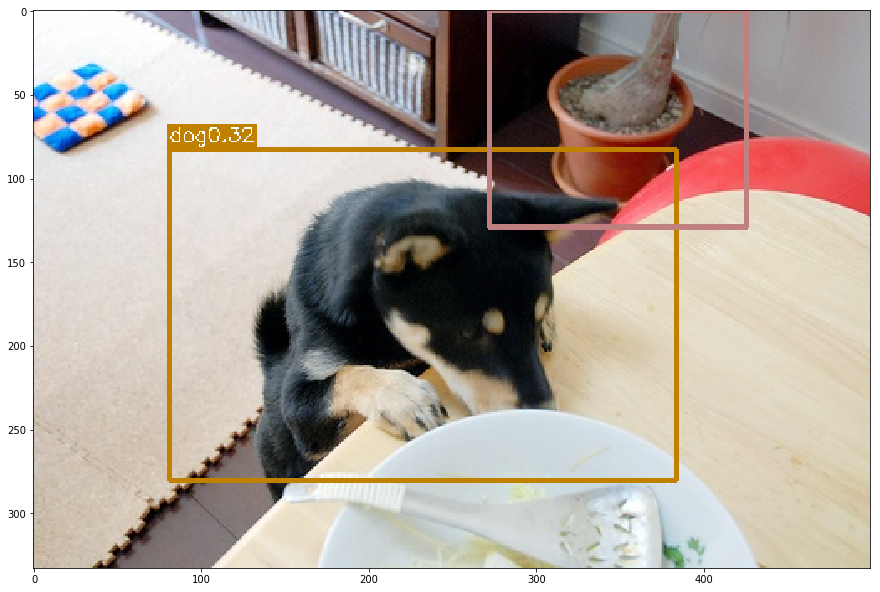

In [10]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [11]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:45<00:00, 29.87it/s]


---class aeroplane ap 0.4420003998064223---
---class bicycle ap 0.6231354748842958---
---class bird ap 0.4651185302992713---
---class boat ap 0.23673331033736233---
---class bottle ap 0.1805988712973443---
---class bus ap 0.6110381390529425---
---class car ap 0.6463257180956071---
---class cat ap 0.714802442891229---
---class chair ap 0.32208158090331185---
---class cow ap 0.5153431394557259---
---class diningtable ap 0.3099033590060779---
---class dog ap 0.6153448026283326---
---class horse ap 0.6898247815961045---
---class motorbike ap 0.553187791431618---
---class person ap 0.5143320132499212---
---class pottedplant ap 0.18182869887225622---
---class sheep ap 0.4577297495379029---
---class sofa ap 0.4927174743359368---
---class train ap 0.631403452332796---
---class tvmonitor ap 0.4871978560939636---
---map 0.48453237930542115---


In [12]:
output_submission_csv('my_solution.csv', test_aps)